<a href="https://colab.research.google.com/github/OlegV12/Neural/blob/Lesson_8/Lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Попробуем обучить GAN на CIFAR10

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds

In [2]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [3]:
#cifar 10
class_ = 0
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.cifar10.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_digits = all_digits[ind_i,:,:]
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

170508288/170498071 [==============================] - 4s 0us/step


In [4]:
import matplotlib.pyplot as plt


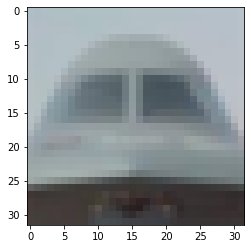

In [5]:
plt.imshow(all_digits[107])
plt.show()

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(8 * 8 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                               

In [7]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [8]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        image = generated_images.numpy()
        plt.figure(figsize = (self.num_img*4, 4))
        for i in range(self.num_img):
          plt.subplot(1,self.num_img,i+1)
          plt.imshow(image[i,:,:,0])
        plt.show()
        #for i in range(self.num_img):
        #    img = keras.preprocessing.image.array_to_img(generated_images[i])
        #    img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


Epoch 1/10
157/157 [==============================] - ETA: 0s - d_loss: 0.5664 - g_loss: 0.9847

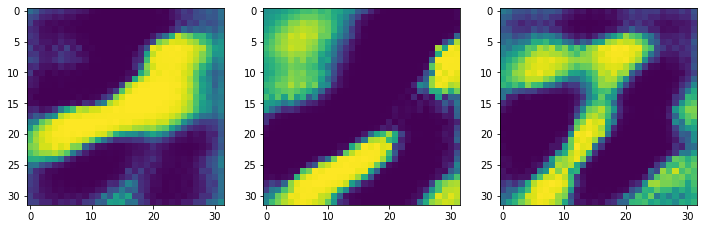

157/157 [==============================] - 35s 129ms/step - d_loss: 0.5667 - g_loss: 0.9835
Epoch 2/10
156/157 [============================>.] - ETA: 0s - d_loss: 0.5697 - g_loss: 1.2063

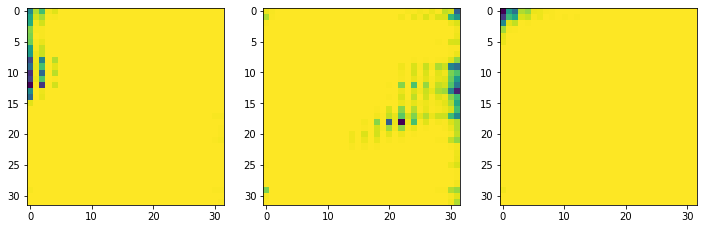

157/157 [==============================] - 20s 127ms/step - d_loss: 0.5646 - g_loss: 1.2183
Epoch 3/10
157/157 [==============================] - ETA: 0s - d_loss: 0.3558 - g_loss: 2.0700

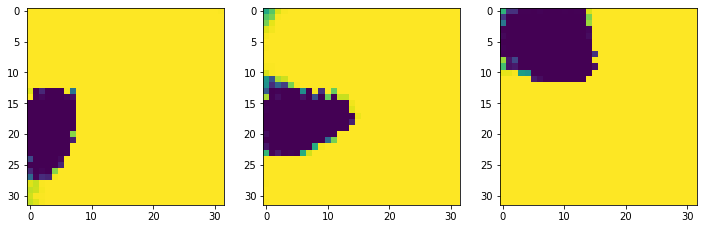

157/157 [==============================] - 20s 128ms/step - d_loss: 0.3538 - g_loss: 2.0803
Epoch 4/10
157/157 [==============================] - ETA: 0s - d_loss: 0.3679 - g_loss: 1.7908

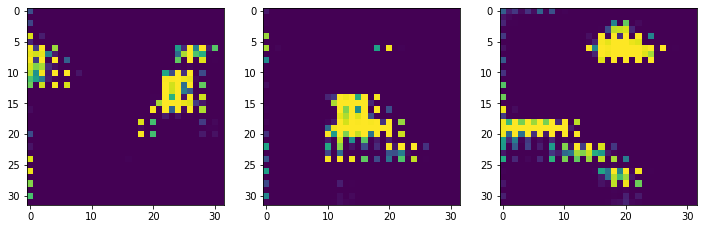

157/157 [==============================] - 21s 131ms/step - d_loss: 0.3665 - g_loss: 1.7924
Epoch 5/10
157/157 [==============================] - ETA: 0s - d_loss: 0.3075 - g_loss: 2.0980

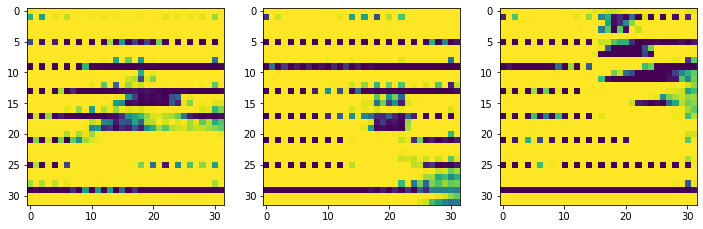

157/157 [==============================] - 21s 131ms/step - d_loss: 0.3083 - g_loss: 2.0995
Epoch 6/10
157/157 [==============================] - ETA: 0s - d_loss: 0.3696 - g_loss: 2.0075

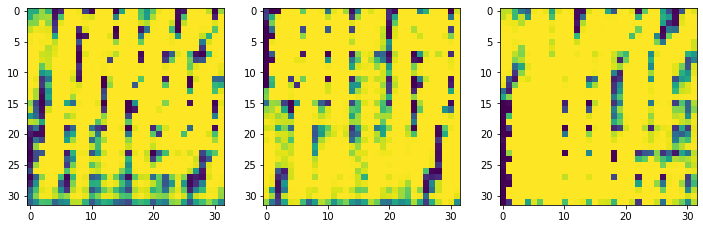

157/157 [==============================] - 20s 130ms/step - d_loss: 0.3677 - g_loss: 2.0148
Epoch 7/10
157/157 [==============================] - ETA: 0s - d_loss: 0.4400 - g_loss: 1.6013

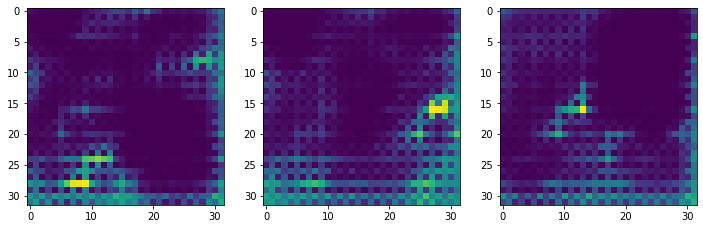

157/157 [==============================] - 21s 131ms/step - d_loss: 0.4378 - g_loss: 1.6059
Epoch 8/10
157/157 [==============================] - ETA: 0s - d_loss: 0.6524 - g_loss: 0.9839

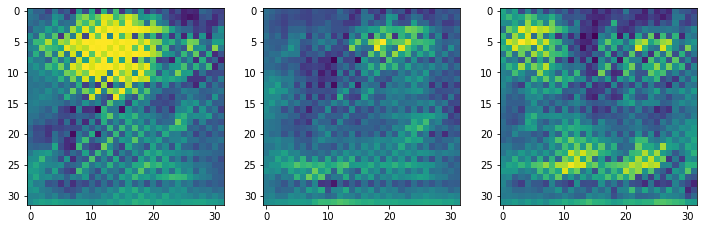

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6504 - g_loss: 0.9860
Epoch 9/10
157/157 [==============================] - ETA: 0s - d_loss: 0.7080 - g_loss: 0.9678

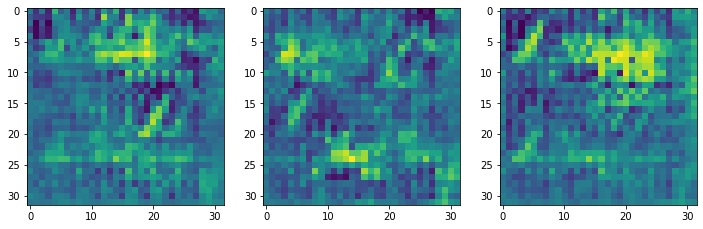

157/157 [==============================] - 20s 130ms/step - d_loss: 0.7058 - g_loss: 0.9698
Epoch 10/10
157/157 [==============================] - ETA: 0s - d_loss: 0.6735 - g_loss: 0.9210

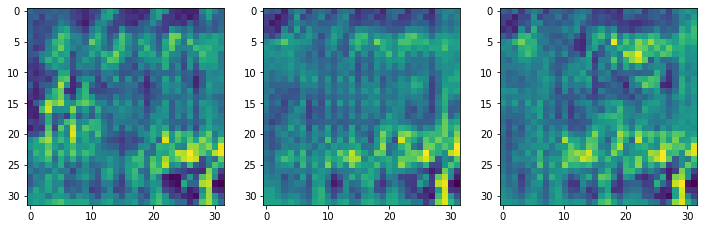

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6719 - g_loss: 0.9220


In [9]:
epochs = 10

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6923 - g_loss: 0.9018

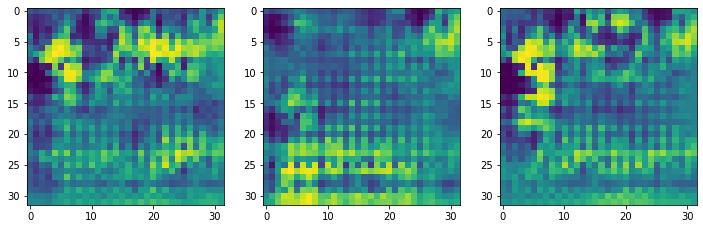

157/157 [==============================] - 22s 137ms/step - d_loss: 0.6907 - g_loss: 0.9027
Epoch 2/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6877 - g_loss: 0.8240

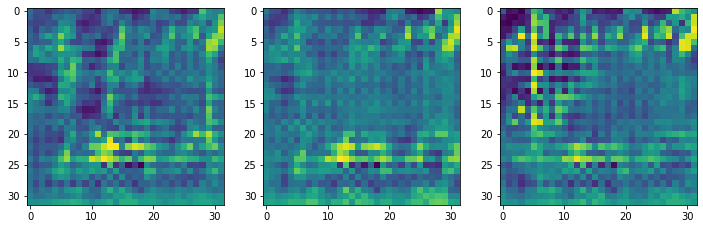

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6860 - g_loss: 0.8257
Epoch 3/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6455 - g_loss: 1.0298

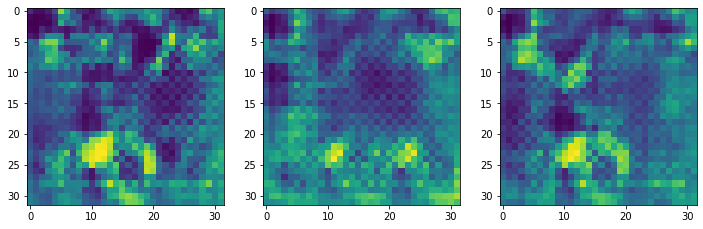

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6442 - g_loss: 1.0302
Epoch 4/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6722 - g_loss: 0.8745

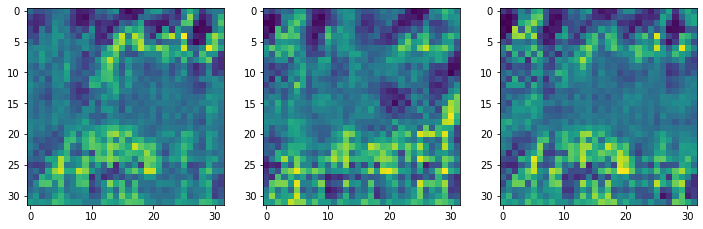

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6710 - g_loss: 0.8749
Epoch 5/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7136 - g_loss: 0.8765

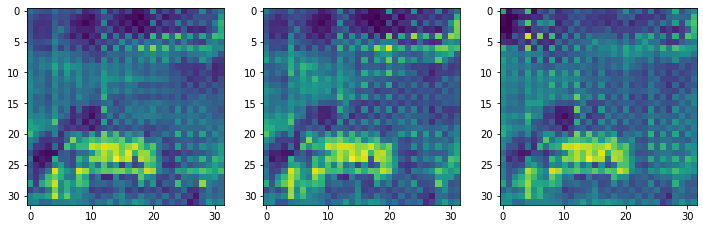

157/157 [==============================] - 21s 131ms/step - d_loss: 0.7125 - g_loss: 0.8766
Epoch 6/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6511 - g_loss: 0.9276

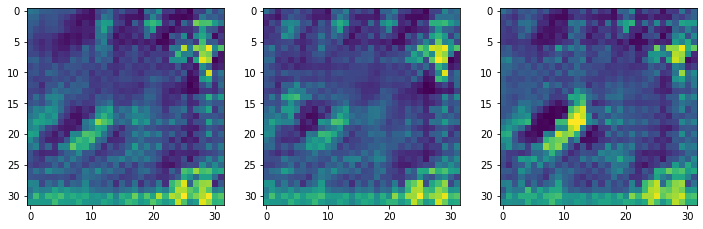

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6489 - g_loss: 0.9297
Epoch 7/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6178 - g_loss: 0.9387

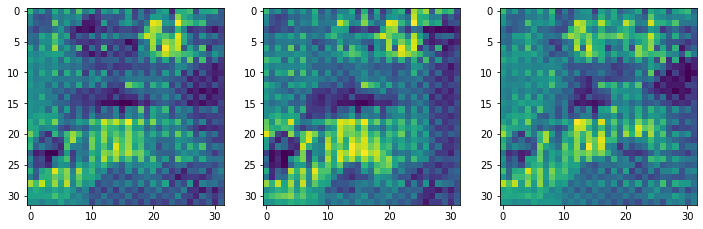

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6165 - g_loss: 0.9403
Epoch 8/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6679 - g_loss: 1.0430

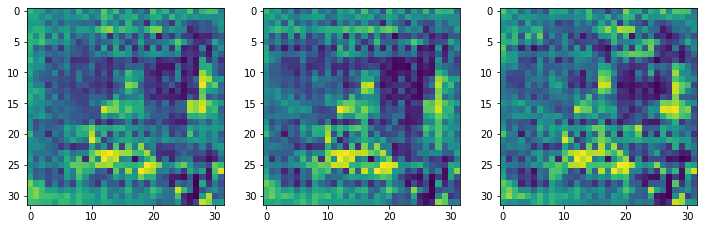

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6669 - g_loss: 1.0435
Epoch 9/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7204 - g_loss: 0.8933

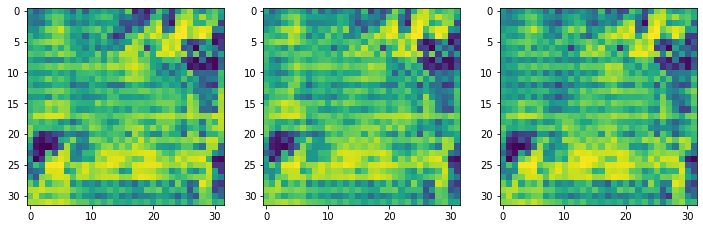

157/157 [==============================] - 21s 131ms/step - d_loss: 0.7189 - g_loss: 0.8948
Epoch 10/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6381 - g_loss: 0.9805

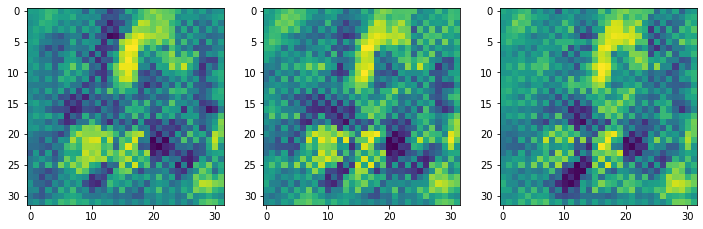

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6362 - g_loss: 0.9829
Epoch 11/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6691 - g_loss: 0.9733

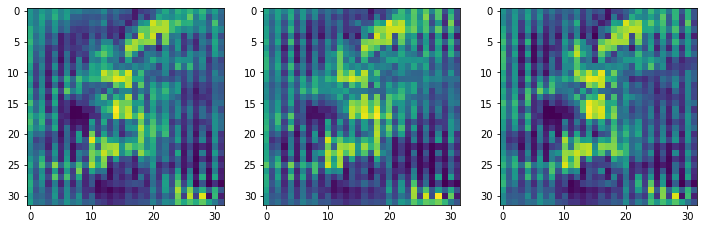

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6677 - g_loss: 0.9750
Epoch 12/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6227 - g_loss: 1.0815

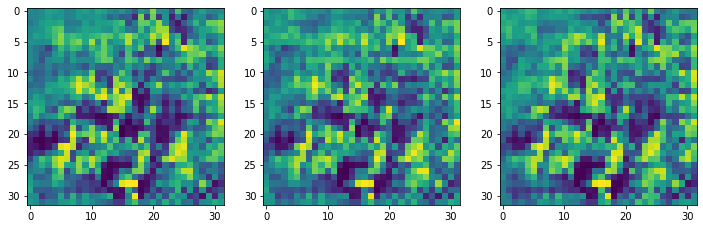

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6211 - g_loss: 1.0822
Epoch 13/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7012 - g_loss: 0.9146

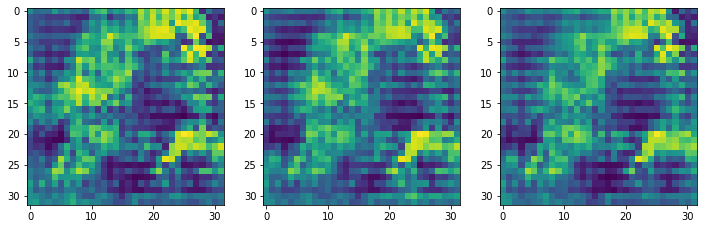

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6993 - g_loss: 0.9164
Epoch 14/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7103 - g_loss: 0.8856

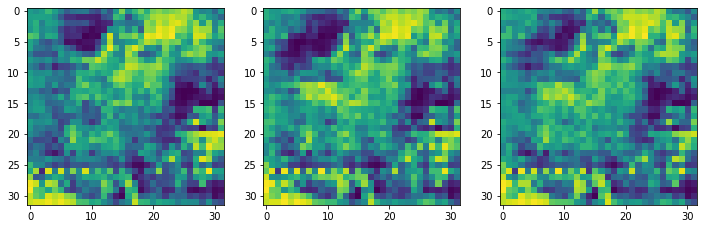

157/157 [==============================] - 21s 131ms/step - d_loss: 0.7094 - g_loss: 0.8859
Epoch 15/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7383 - g_loss: 0.8820

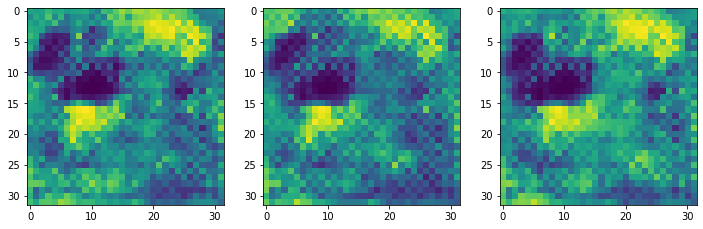

157/157 [==============================] - 21s 132ms/step - d_loss: 0.7366 - g_loss: 0.8834
Epoch 16/40
157/157 [==============================] - ETA: 0s - d_loss: 0.7056 - g_loss: 0.8892

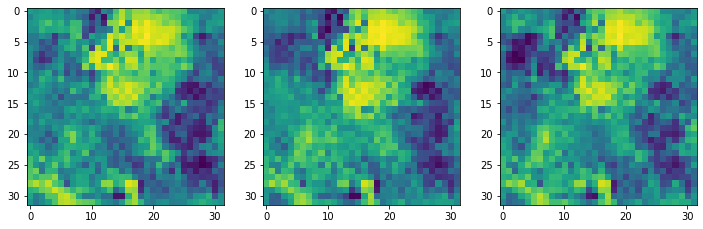

157/157 [==============================] - 21s 132ms/step - d_loss: 0.7045 - g_loss: 0.8903
Epoch 17/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6276 - g_loss: 0.9903

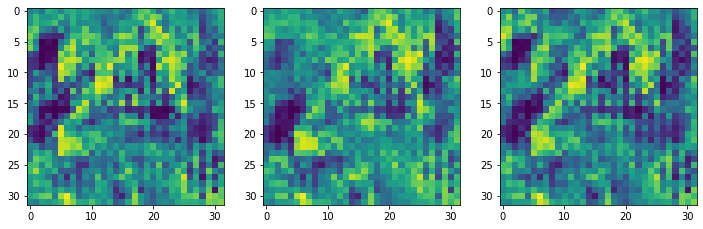

157/157 [==============================] - 21s 134ms/step - d_loss: 0.6263 - g_loss: 0.9910
Epoch 18/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6899 - g_loss: 0.8723

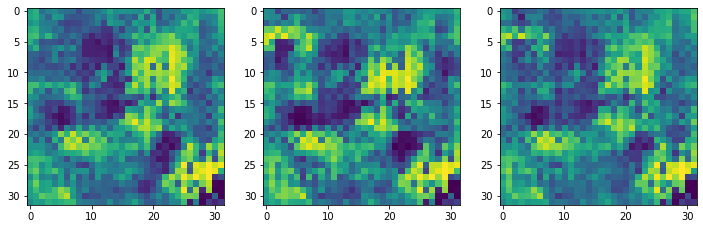

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6895 - g_loss: 0.8739
Epoch 19/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6537 - g_loss: 1.0028

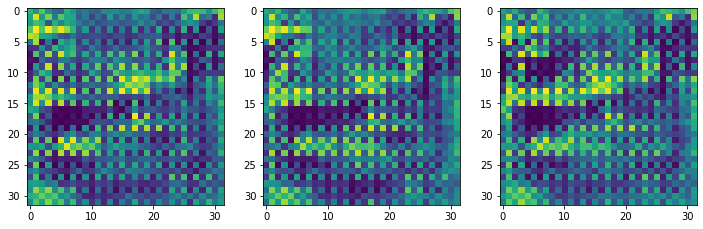

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6516 - g_loss: 1.0046
Epoch 20/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6497 - g_loss: 1.0178

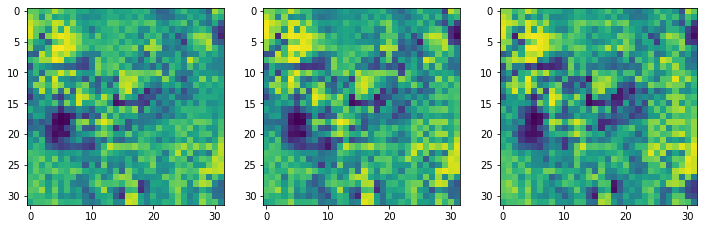

157/157 [==============================] - 20s 131ms/step - d_loss: 0.6482 - g_loss: 1.0187
Epoch 21/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.9416

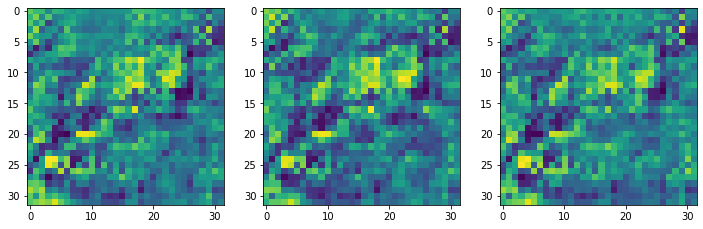

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6706 - g_loss: 0.9421
Epoch 22/40
156/157 [============================>.] - ETA: 0s - d_loss: 0.6940 - g_loss: 0.9073

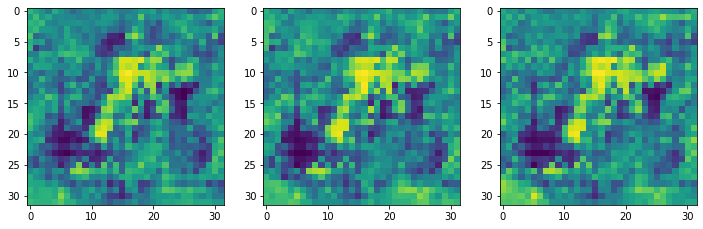

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6906 - g_loss: 0.9106
Epoch 23/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.9164

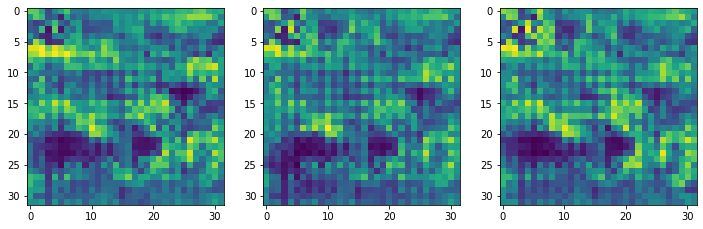

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6670 - g_loss: 0.9179
Epoch 24/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6615 - g_loss: 1.0328

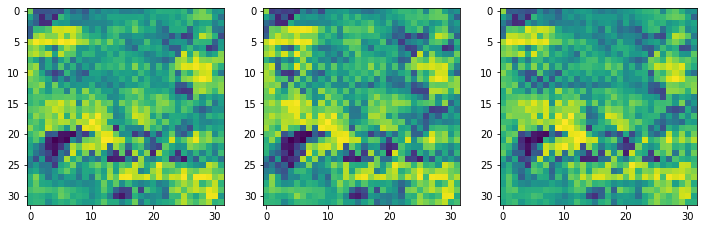

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6596 - g_loss: 1.0340
Epoch 25/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6799 - g_loss: 0.9262

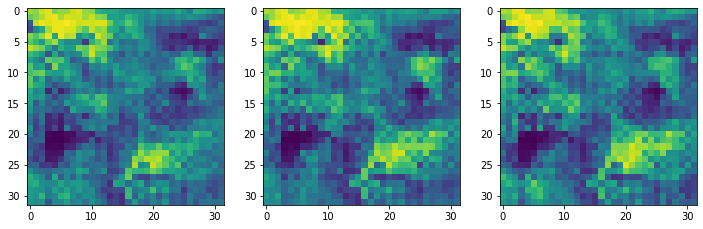

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6785 - g_loss: 0.9266
Epoch 26/40
156/157 [============================>.] - ETA: 0s - d_loss: 0.6750 - g_loss: 0.9329

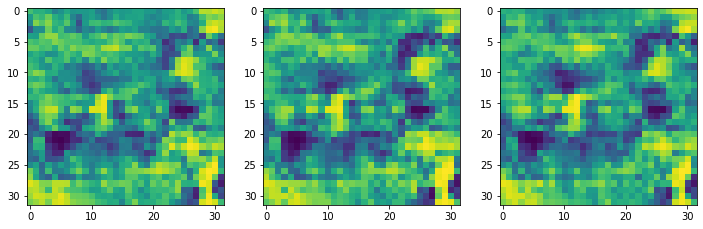

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6720 - g_loss: 0.9350
Epoch 27/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6354 - g_loss: 1.0142

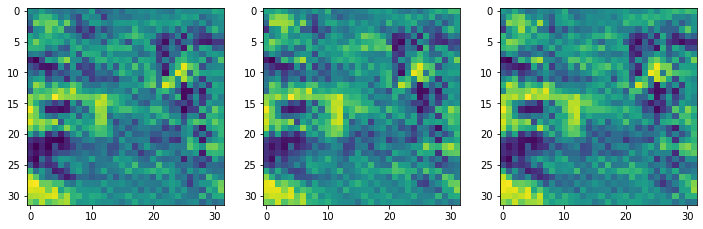

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6340 - g_loss: 1.0148
Epoch 28/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6978 - g_loss: 0.8845

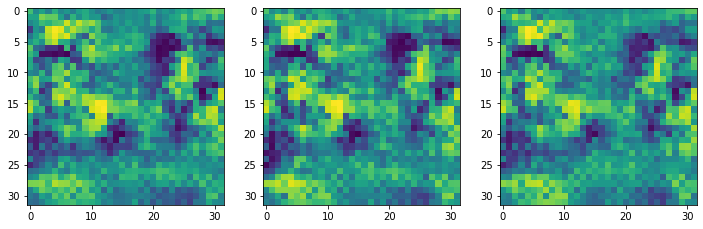

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6962 - g_loss: 0.8857
Epoch 29/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6699 - g_loss: 0.9537

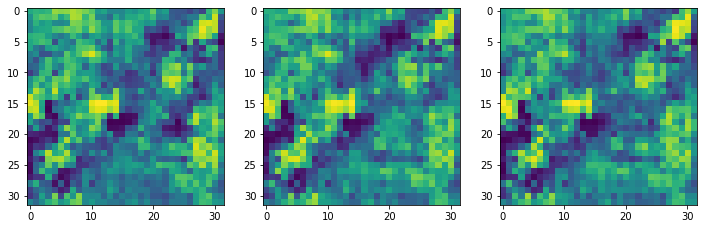

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6678 - g_loss: 0.9554
Epoch 30/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6385 - g_loss: 1.0080

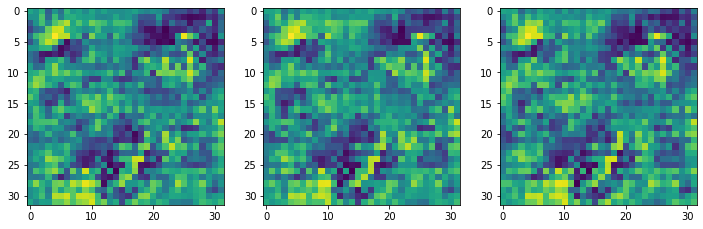

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6367 - g_loss: 1.0093
Epoch 31/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6743 - g_loss: 0.9679

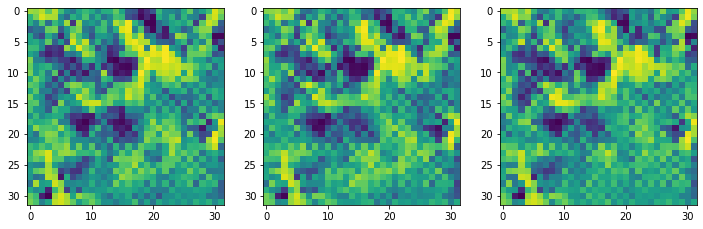

157/157 [==============================] - 21s 133ms/step - d_loss: 0.6730 - g_loss: 0.9687
Epoch 32/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6313 - g_loss: 0.9644

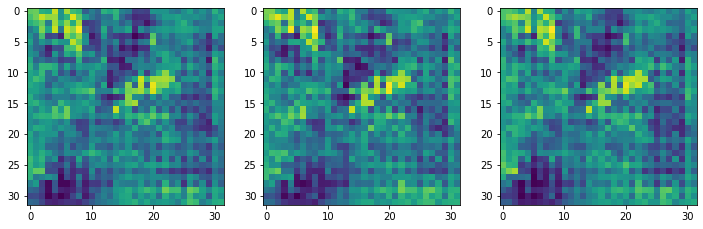

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6298 - g_loss: 0.9653
Epoch 33/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6488 - g_loss: 1.0377

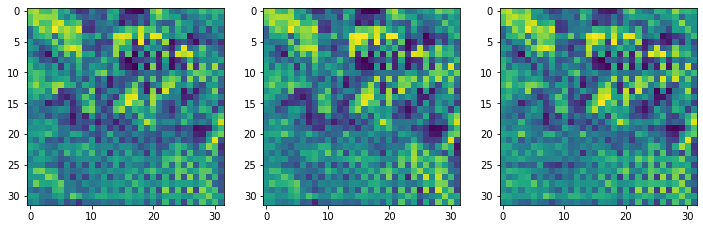

157/157 [==============================] - 21s 132ms/step - d_loss: 0.6487 - g_loss: 1.0380
Epoch 34/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6582 - g_loss: 1.0456

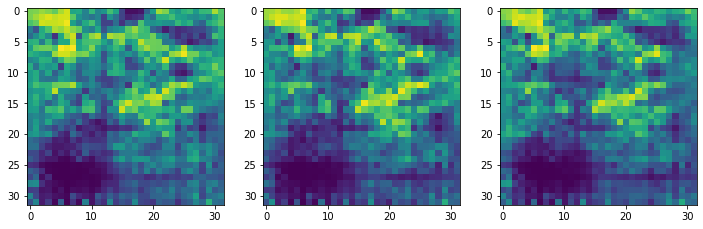

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6565 - g_loss: 1.0459
Epoch 35/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6280 - g_loss: 1.0020

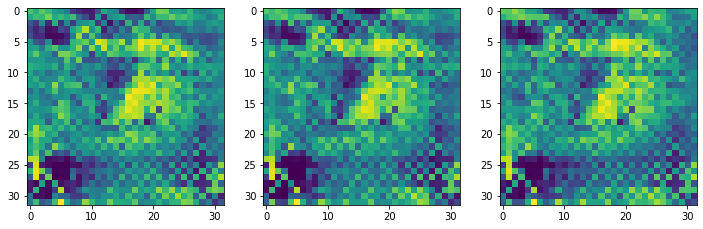

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6263 - g_loss: 1.0038
Epoch 36/40
156/157 [============================>.] - ETA: 0s - d_loss: 0.6202 - g_loss: 1.0923

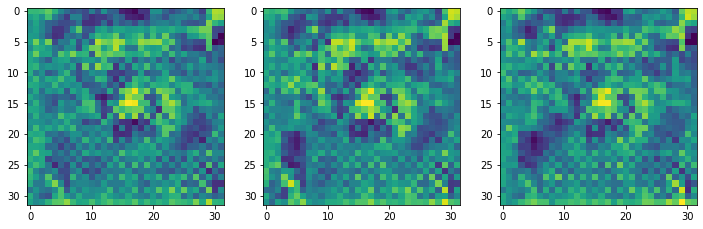

157/157 [==============================] - 20s 130ms/step - d_loss: 0.6167 - g_loss: 1.0940
Epoch 37/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6985 - g_loss: 0.9693

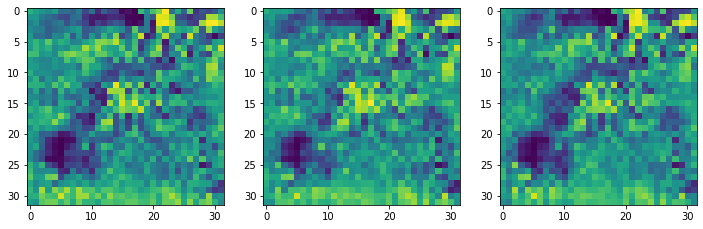

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6967 - g_loss: 0.9700
Epoch 38/40
156/157 [============================>.] - ETA: 0s - d_loss: 0.6745 - g_loss: 0.9754

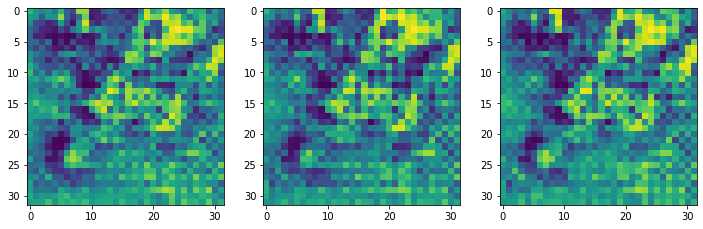

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6717 - g_loss: 0.9763
Epoch 39/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6990 - g_loss: 0.9366

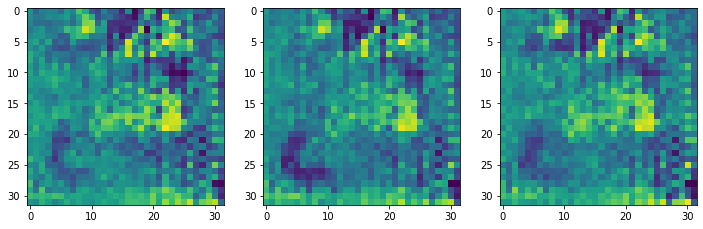

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6979 - g_loss: 0.9362
Epoch 40/40
157/157 [==============================] - ETA: 0s - d_loss: 0.6772 - g_loss: 0.9053

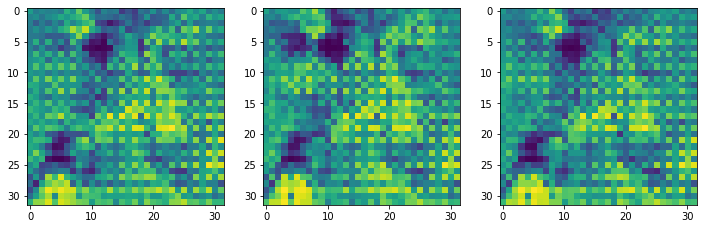

157/157 [==============================] - 21s 131ms/step - d_loss: 0.6758 - g_loss: 0.9073


In [10]:
history = gan.fit(
    dataset, epochs=40, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

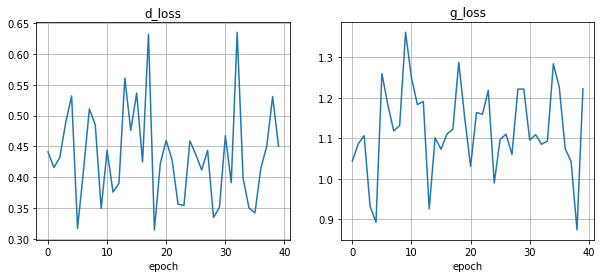

In [11]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(history.history['d_loss'])
plt.title('d_loss')
plt.xlabel('epoch')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['g_loss'])
plt.title('g_loss')
plt.xlabel('epoch')
plt.grid(True)
2

plt.show()

In [12]:
I = gan.generator(tf.random.normal(shape=(1, gan.latent_dim)))

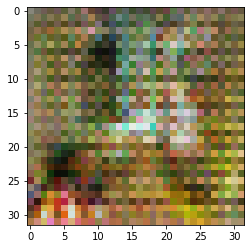

In [15]:
plt.imshow(I[0])
plt.show()

Думаю что в целом обучение генератора на данном датасете не принесет результатов из-за того, что обекты класса тут представлены с разных ракурсов.

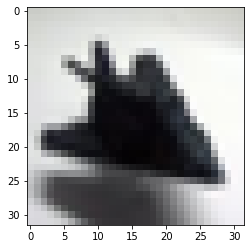

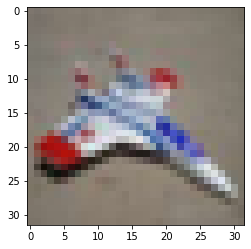

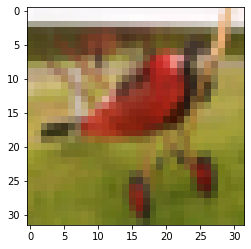

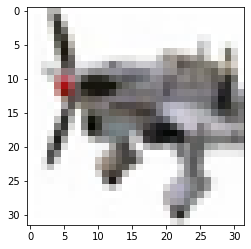

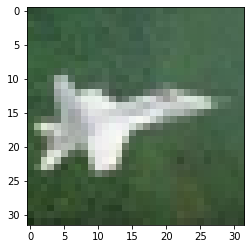

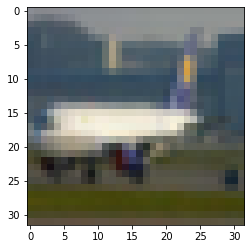

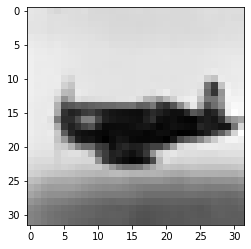

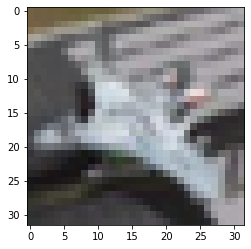

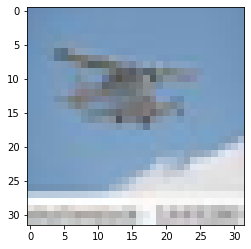

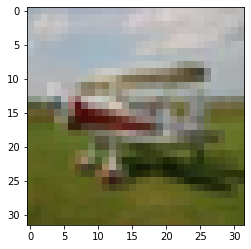

In [20]:
for i in range(10):
    plt.imshow(all_digits[i])
    plt.show()